In [1]:
from scipy.io import savemat
import scipy.io     # used to load .mat data

import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import seaborn as sns

from models import TandemNet, MLP ,cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, MLP_sigmoid
from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, cVAE_Full, cVAE_hybrid, cVAE_tandem, cVAE_GSNN1
from utils import evaluate_tandem_minmax_accuracy, evaluate_forward_minmax_dataset, evaluate_forward_minmax, evaluate_vae_GSNN_minmax_inverse, evaluate_gan_minmax_inverse, evaluate_inn_minmax_inverse

from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred, plt_abs_err, plt_hist_struc, plot_struc_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('forward_model')



# Check forward model 


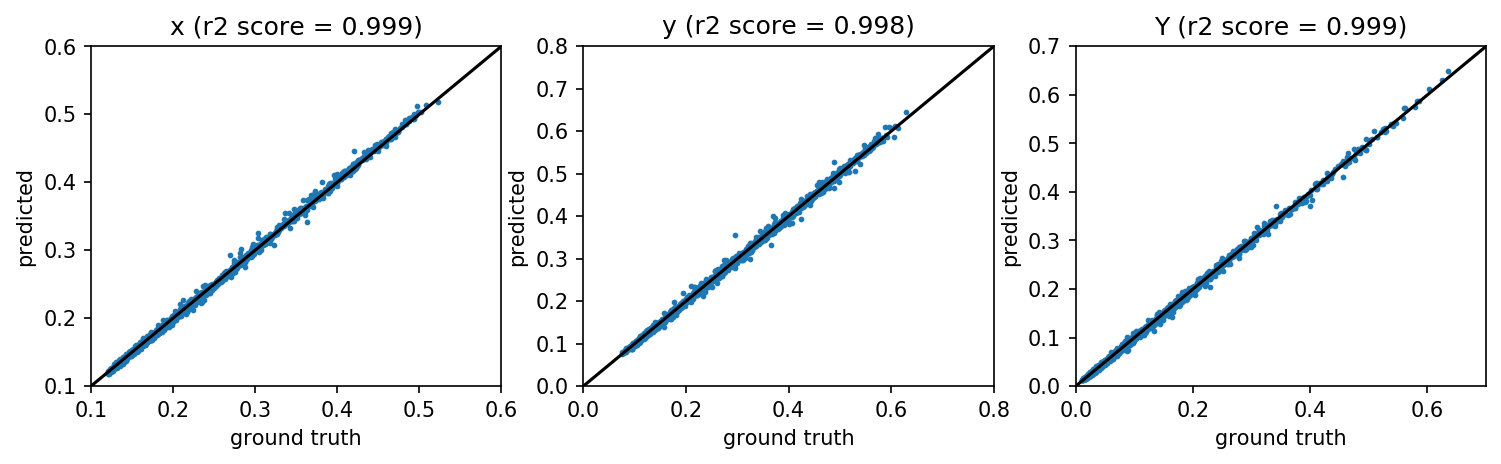

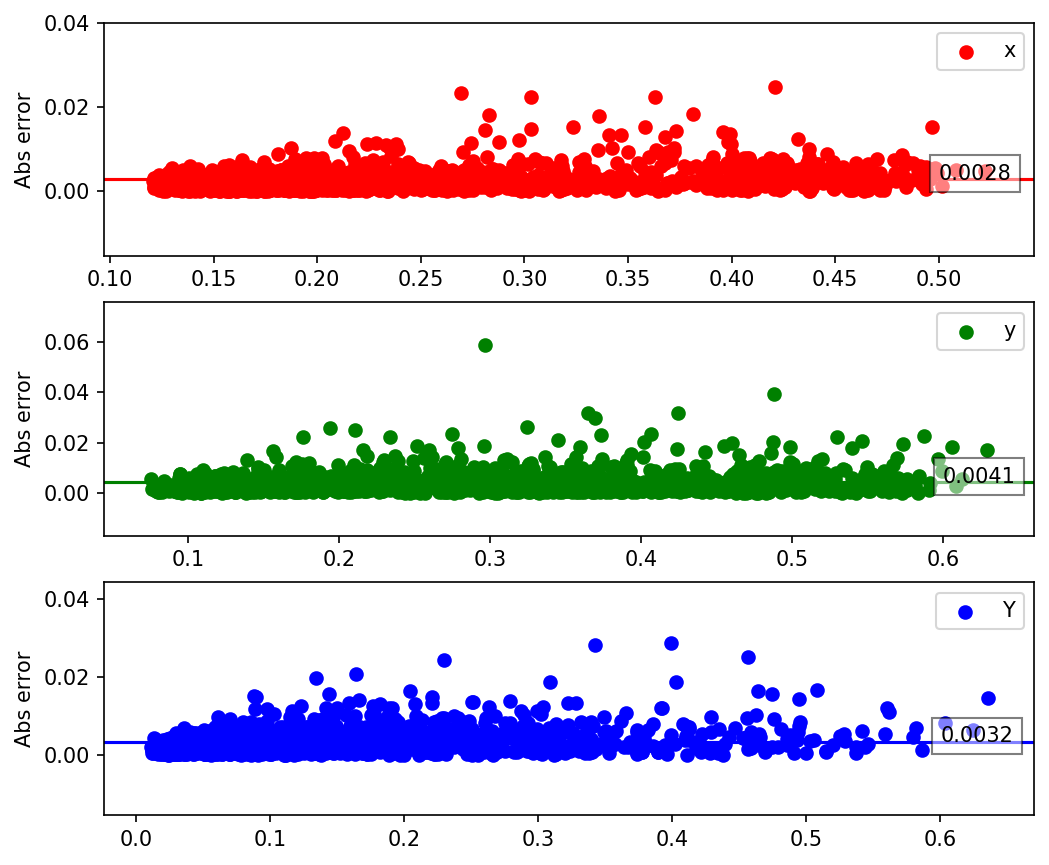

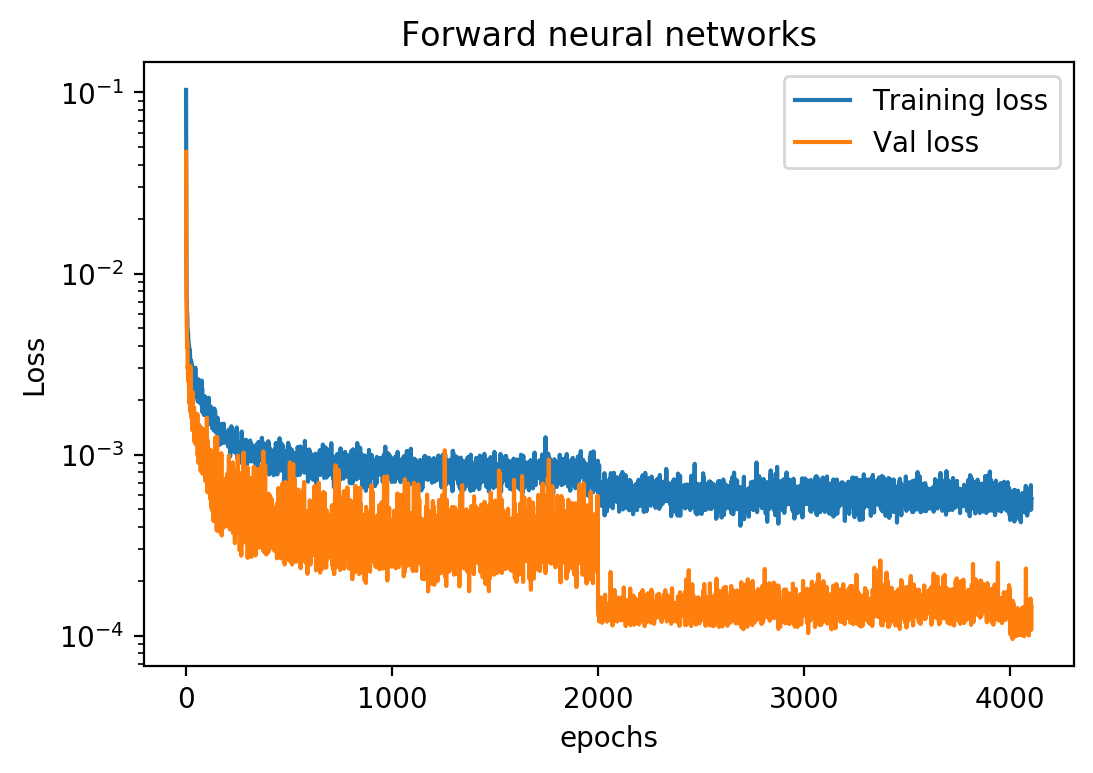

In [2]:
# evaluate the performance of FNNs

train_loader, val_loader, test_loader = get_dataloaders('forward_model')
forward_model_train = MLP(4, 3).to(DEVICE)
forward_path_train = './models/examples/forward__lr_0.001_STEP_False_epoch_5000_trained_evaluate_1.pth'
forward_model_train.load_state_dict(torch.load(forward_path_train)['model_state_dict'])
cie_pred, cie_raw = evaluate_forward_minmax_dataset(forward_model_train, test_loader.dataset, show=0)

plot_cie_raw_pred(cie_raw, cie_pred)
plt_abs_err(cie_raw, cie_pred)


#plot the training and val loss VS epoches.

epochs = torch.load(forward_path_train)['epoch']

loss = torch.load(forward_path_train)['loss_all']
plt.figure(dpi=200)
plt.plot(range(epochs),loss[0,:epochs],label='Training loss')  
plt.plot(range(epochs),loss[1,:epochs],label='Val loss')                     
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Forward neural networks')
plt.legend()



# Evauluate the Tandem networks 

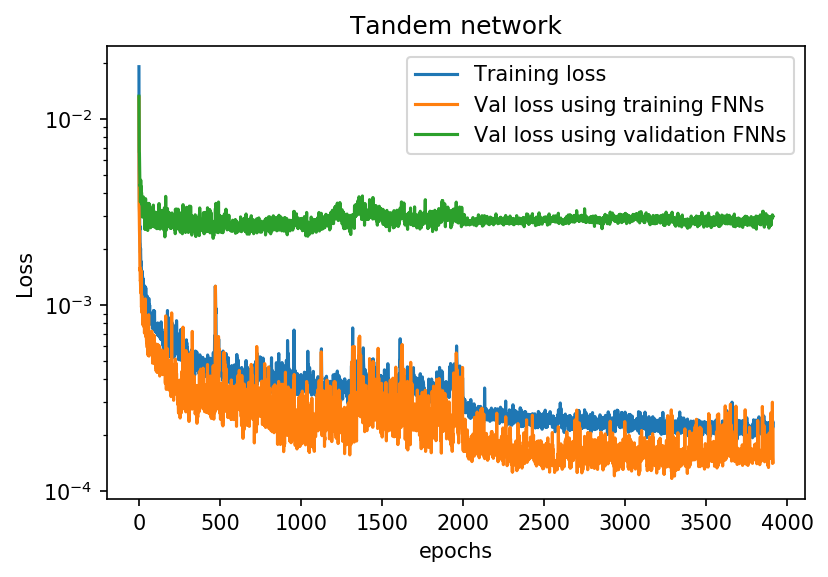

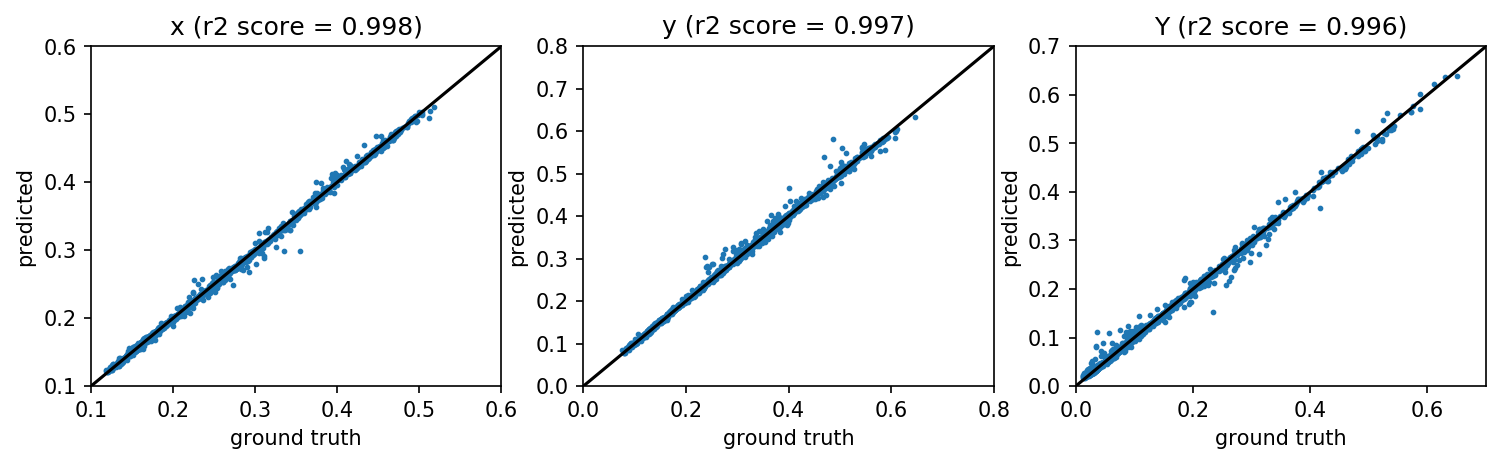

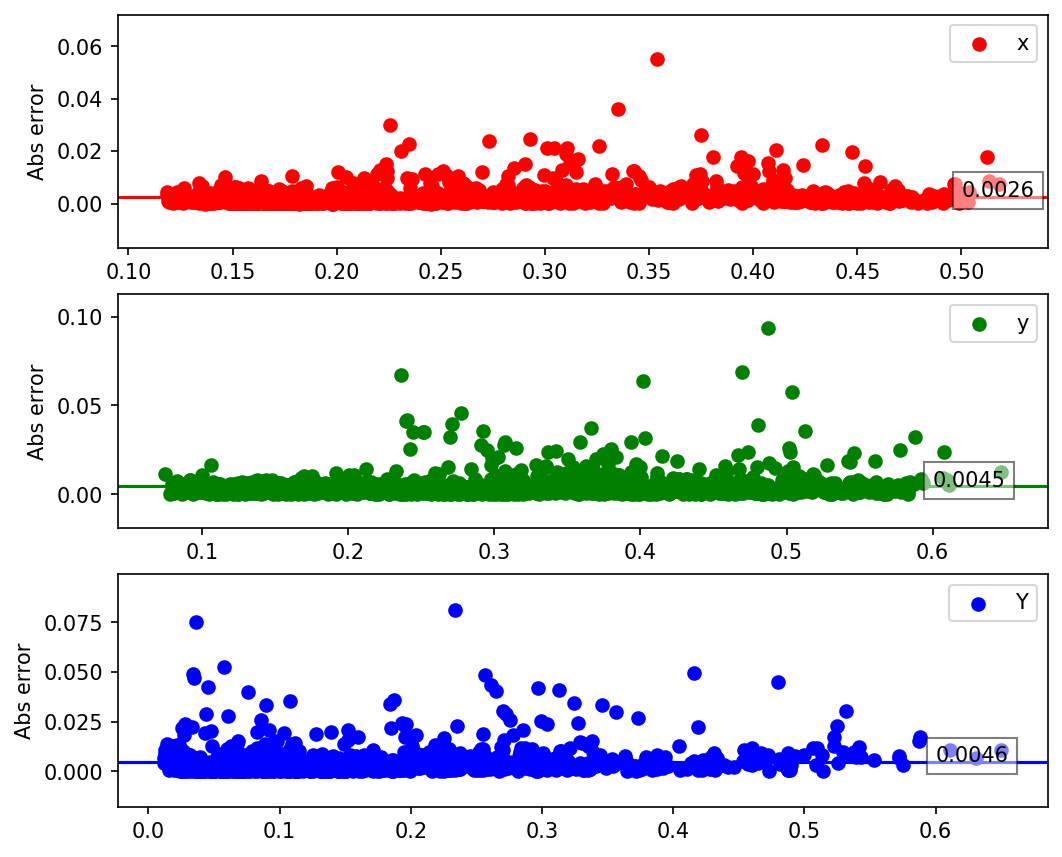

In [9]:
# Tandem networks 

train_loader, val_loader, test_loader = get_dataloaders('forward_model')


forward_model_train = MLP(4, 3).to(DEVICE)
forward_path_train = './models/examples/forward__lr_0.001_STEP_False_epoch_10000_trained_training.pth'
forward_model_train.load_state_dict(torch.load(forward_path_train)['model_state_dict'])

forward_model_evaluate = MLP(4, 3).to(DEVICE)
forward_path_evaluate = './models/examples/forward__lr_0.001_STEP_False_epoch_5000_trained_evaluate_1.pth'
forward_model_evaluate.load_state_dict(torch.load(forward_path_evaluate)['model_state_dict'])

inverse_model = MLP_sigmoid(3, 4).to(DEVICE)
tandem_model = TandemNet(forward_model_train, inverse_model)
tandem_path = './models/examples/tandem_sigmoid_lr_0.0005_STEP_False_epochs_5000_batch_size_128_trained_1.pth'
tandem_model.load_state_dict(torch.load(tandem_path)['model_state_dict'])


epochs = torch.load(tandem_path)['epoch']
gan_loss_all = torch.load(tandem_path)['loss_all']
plt.figure(dpi=150)
plt.plot(range(epochs),gan_loss_all[0,:epochs],label='Training loss')  
plt.plot(range(epochs),gan_loss_all[1,:epochs],label='Val loss using training FNNs')        
plt.plot(range(epochs),gan_loss_all[2,:epochs],label='Val loss using validation FNNs' )                 
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Tandem network')
plt.legend()


# evaluate on the training FNNs
cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_minmax_accuracy(tandem_model, tandem_model.forward_model, test_loader.dataset, show=0)
plot_cie_raw_pred(cie_raw, cie_pred)
plt_abs_err(cie_raw, cie_pred)

# evaluate on the validation FNNs
# cie_raw, param_raw, cie_pred, param_pred = evaluate_tandem_minmax_accuracy(tandem_model, forward_model_evaluate, test_loader.dataset, show=0)
# plot_cie_raw_pred(cie_raw, cie_pred)
# plt_abs_err(cie_raw, cie_pred)

# Check VAE

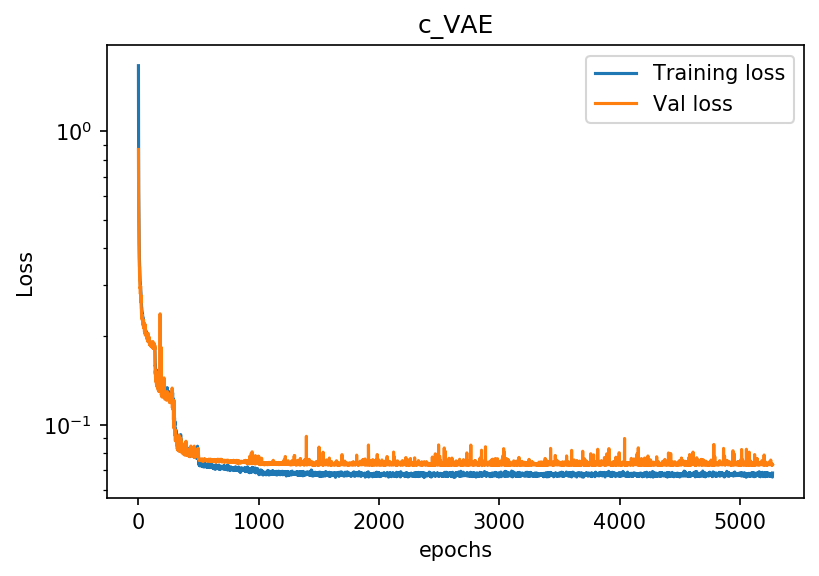

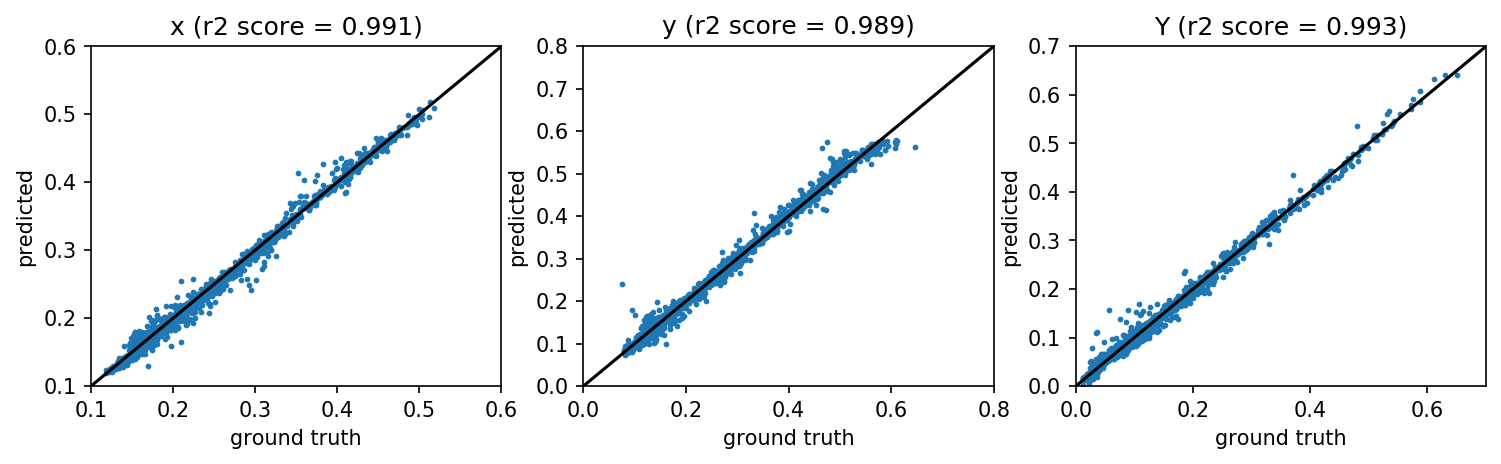

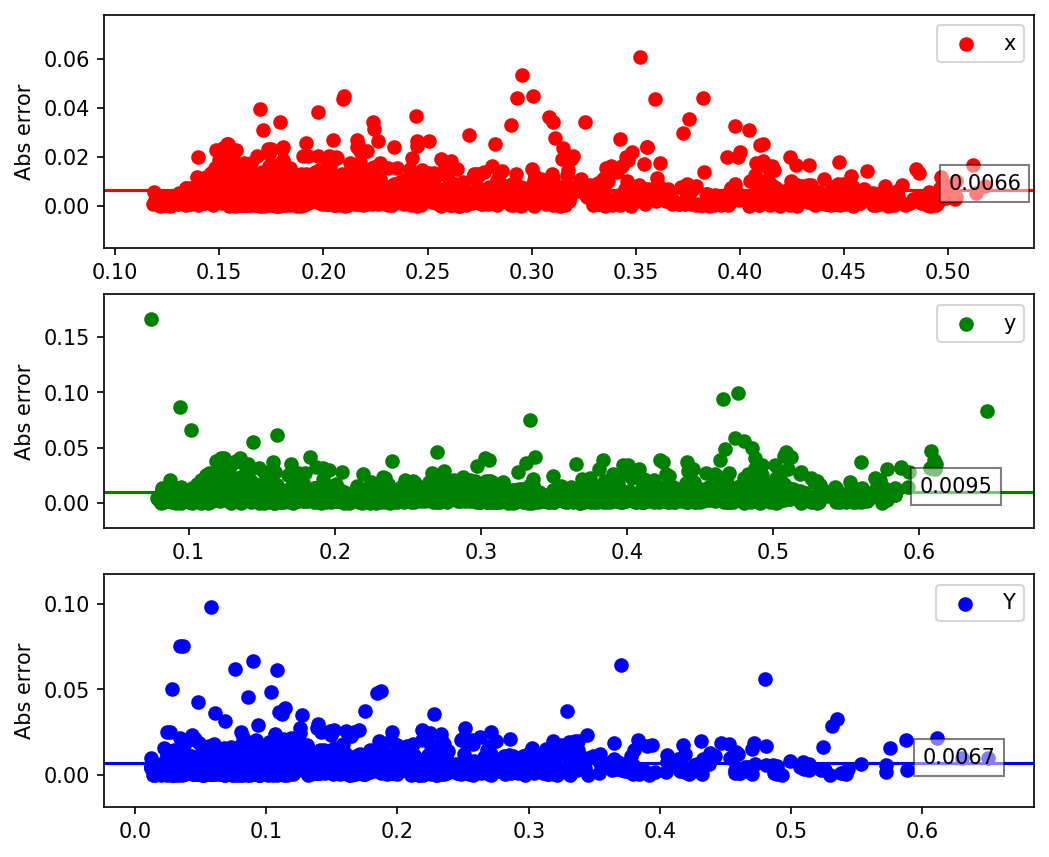

In [10]:
# Train the vae based on forward model, where vae model is GSNN model :

train_loader, val_loader, test_loader = get_dataloaders('forward_model')


forward_model_train = MLP(4, 3).to(DEVICE)
forward_path_train = './models/examples/forward__lr_0.001_STEP_False_epoch_10000_trained_training.pth'
forward_model_train.load_state_dict(torch.load(forward_path_train)['model_state_dict'])

forward_model_evaluate = MLP(4, 3).to(DEVICE)
forward_path_evaluate = './models/examples/forward__lr_0.001_STEP_False_epoch_5000_trained_evaluate_1.pth'
forward_model_evaluate.load_state_dict(torch.load(forward_path_evaluate)['model_state_dict'])



vae_model = cVAE_GSNN1(4, 3).to(DEVICE)
model = cVAE_hybrid(forward_model_train, vae_model)

vae_path = './models/examples/cvae_GSNN_forward_True_latent_3_lr_0.001_STEP_False_epochs_10000_weight_forward_10.0_batch_size_128_trained.pth'
#vae_path = './models/summary/cvae_3_forward_True_latent_3_lr_0.001_STEP_True_epochs_10000_weight_forward_10.0_batch_size_128_trained_2_.pth'
model.load_state_dict(torch.load(vae_path)['model_state_dict'])


epochs = torch.load(vae_path)['epoch']
gan_loss_all = torch.load(vae_path)['loss_all']
plt.figure(dpi=150)
plt.plot(range(epochs),gan_loss_all[0,:epochs],label='Training loss')  
plt.plot(range(epochs),gan_loss_all[1,:epochs],label='Val loss')   
                    
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('c_VAE')
plt.legend()

# evaluate on the training FNNs
cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_GSNN_minmax_inverse(model.vae_model, forward_model_train, test_loader.dataset, show=0)
plot_cie_raw_pred(cie_raw, cie_pred)
plt_abs_err(cie_raw, cie_pred)

# evaluate on the validationn FNNs
# cie_raw, param_raw, cie_pred, param_pred = evaluate_vae_GSNN_minmax_inverse(model.vae_model, forward_model_evaluate, test_loader.dataset, show=0)
# plot_cie_raw_pred(cie_raw, cie_pred)
# plt_abs_err(cie_raw, cie_pred)


# Check GAN

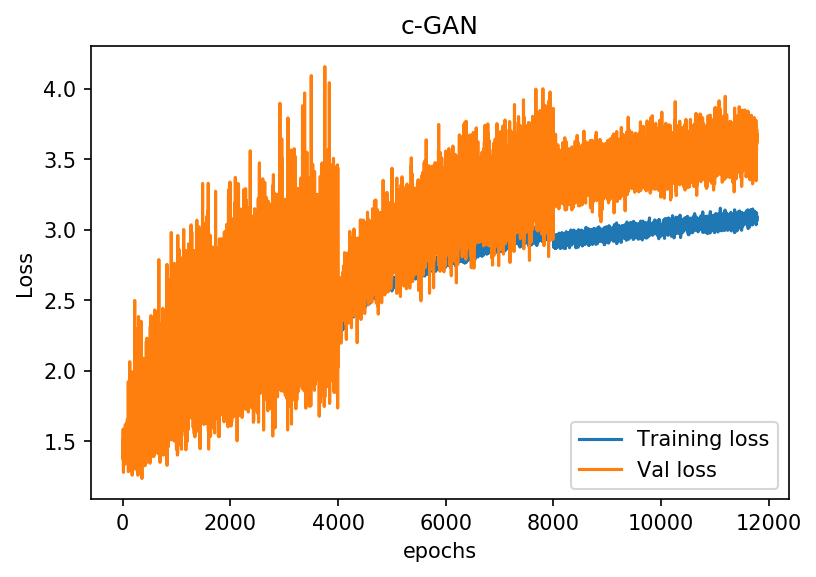

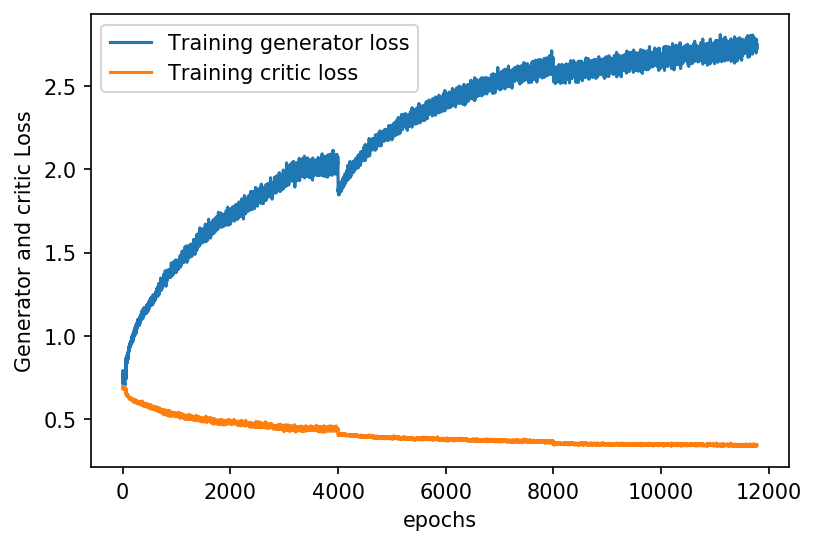

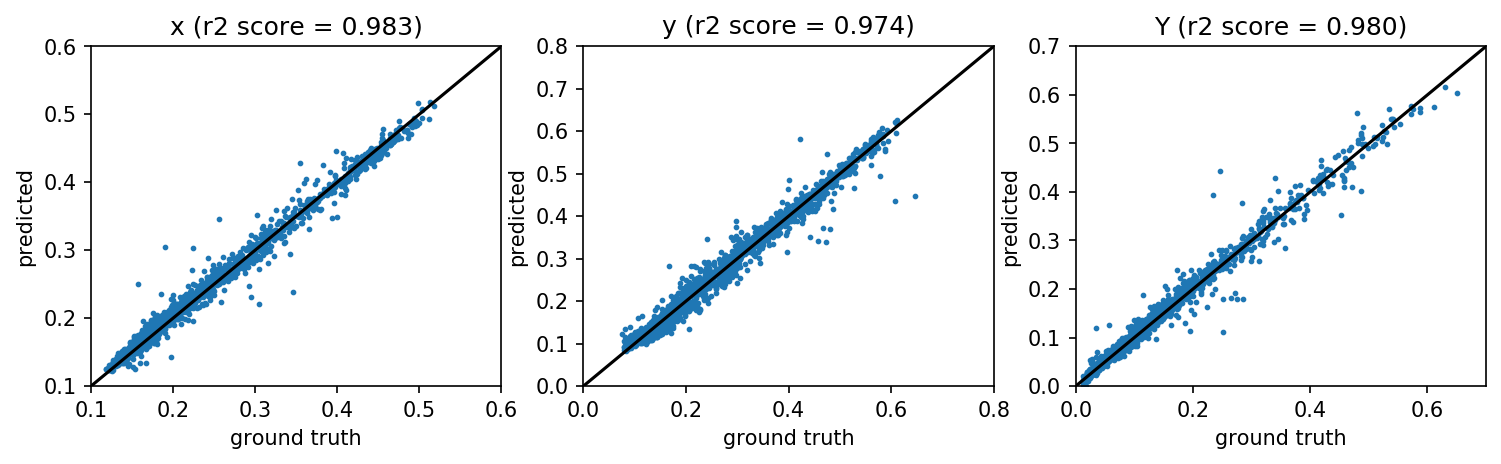

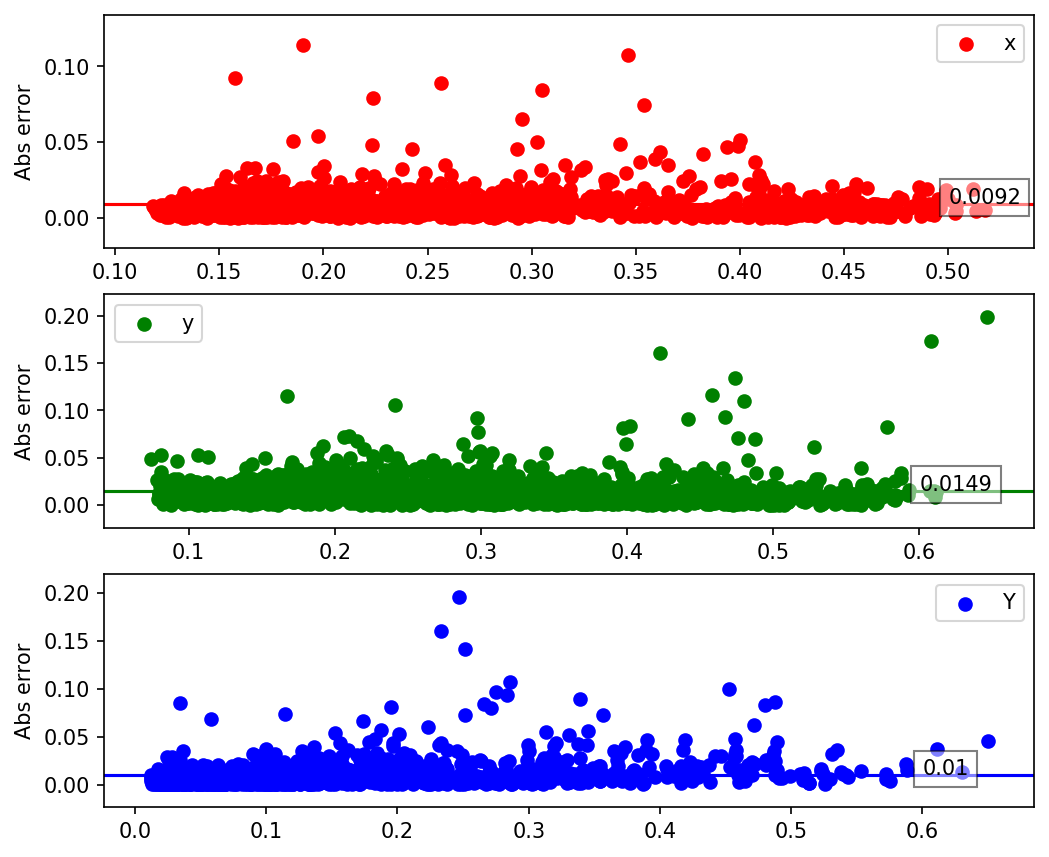

In [18]:
# Evaluate the performance of GAN
train_loader, val_loader, test_loader = get_dataloaders('gan')

forward_model_evaluate = MLP(4, 3).to(DEVICE)
forward_path_evaluate = './models/examples/forward__lr_0.001_STEP_False_epoch_5000_trained_evaluate_1.pth'
forward_model_evaluate.load_state_dict(torch.load(forward_path_evaluate)['model_state_dict'])


gan_model = cGAN(3, 4, 2).to(DEVICE)
gan_path = './models/examples/cgan_3_batch_128_epoch_20000_4000_noise_2_g_0.0005_d_0.0005_STEP_False1_temp.pth'
gan_path = './models/trained/cgan_3_batch_128_epoch_20000_4000_noise_2_g_0.0005_d_0.0005_STEP_False1_.pth'

epochs = torch.load(gan_path)['epoch']
gan_loss_all = torch.load(gan_path)['loss_all']
plt.figure(dpi=150)
plt.plot(range(epochs),gan_loss_all[0,:epochs],label='Training loss')  
plt.plot(range(epochs),gan_loss_all[1,:epochs],label='Val loss')                     
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('c-GAN')
plt.legend()

plt.figure(dpi=150)
plt.plot(range(epochs),gan_loss_all[3,:epochs],label='Training generator loss')  
plt.plot(range(epochs),gan_loss_all[4,:epochs],label='Training critic loss')                     
plt.xlabel('epochs')
plt.ylabel('Generator and critic Loss')
plt.legend()


gan_model.load_state_dict(torch.load(gan_path)['model_state_dict'])
cie_raw, param_raw, cie_pred, param_pred= evaluate_gan_minmax_inverse(gan_model, forward_model_evaluate, test_loader.dataset, show=0)
plot_cie_raw_pred(cie_raw, cie_pred)
plt_abs_err(cie_raw, cie_pred)